## When Deep Learning Met Code Search

https://arxiv.org/pdf/1905.03813.pdf

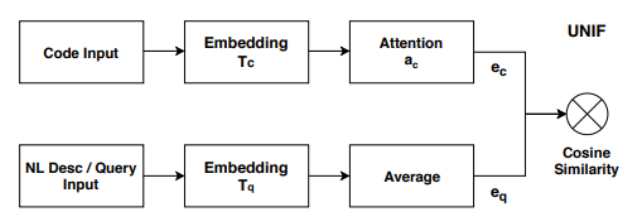

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import random
import numpy as np
from tqdm import tqdm
import json
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences

/Users/nicola/Documents/GitHub/SkCoder/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Dataset

In [2]:
def read_file(path):
    file = open(path, 'r')
    return file.read()

In [3]:
def extract_tokens_from_jsonl(jsonl_file, input_tokens_file, output_tokens_file):
    with open(jsonl_file, 'r') as jf, \
         open(input_tokens_file, 'w') as inf, \
         open(output_tokens_file, 'w') as outf:
        for line in jf:
            data = json.loads(line)
            input_tokens = ' '.join(data['input_tokens'])
            output_tokens = ' '.join(data['output_tokens'])
            inf.write(input_tokens + '\n')
            outf.write(output_tokens + '\n')

In [4]:
def  build_tokenfiles(data_path, output_path):
    #if path not exist create
    if not os.path.exists('data/' + output_path):
        os.makedirs('data/' + output_path)
    for prefix in ['train', 'dev', 'test']:
        extract_tokens_from_jsonl(data_path + prefix + '.jsonl',
                                   'data/' + output_path + prefix + '.input_tokens.txt',
                                   'data/' + output_path + prefix + '.output_tokens.txt')

The dataset from [Deep code search](https://dl.acm.org/doi/10.1145/3180155.3180167) repository ([link](https://github.com/guxd/deep-code-search)) comes in h5 format and should be dowloaded from [drive](https://drive.google.com/drive/folders/1GZYLT_lzhlVczXjD6dgwVUvDDPHMB6L7).

In [5]:
data_path = "../data/AixBench-L/bachelor/"
output_path = "AixBench-L/"
build_tokenfiles(data_path, output_path)

In [6]:
def create_list_from_files(folder):
    train_desc = []
    train_code = []
    train_bad_desc = []
    dev_desc = []
    dev_code = []
    dev_bad_desc = []
    test_desc = []
    test_code = []
    test_bad_desc = []
    for prefix in ['train', 'dev', 'test']:
        with open(folder + prefix + '.input_tokens.txt', 'r') as f:
            input_tokens = f.read().splitlines()
        with open(folder + prefix + '.output_tokens.txt', 'r') as f:
            output_tokens = f.readlines()
        if prefix == 'train':
            train_desc = input_tokens
            train_code = output_tokens
            train_bad_desc = input_tokens[:] 
            random.shuffle(train_bad_desc)
        elif prefix == 'dev':
            dev_desc = input_tokens
            dev_code = output_tokens
            dev_bad_desc = input_tokens[:]
            random.shuffle(dev_bad_desc)
        else:
            test_desc = input_tokens
            test_code = output_tokens
            test_bad_desc = input_tokens[:]
            random.shuffle(test_bad_desc)
    return train_desc, train_code, train_bad_desc, dev_desc, dev_code, dev_bad_desc, test_desc, test_code, test_bad_desc



In [7]:
train_desc, train_code, train_bad_desc, dev_desc, dev_code, dev_bad_desc, test_desc, test_code, test_bad_desc = create_list_from_files('data/' + output_path)

In [8]:
def escape(text):
    # Escape special characters in the text
    special_chars = ["\\", "+", "-", "&", "|", "!", "(", ")", "{", "}", "[", "]", "^", "\"", "~", "*", "?", ":", "/", "OR", "AND", "NOT"]
    for char in special_chars:
        text = text.replace(char, f"\\{char}")
    # Replace specific words with placeholders
    text = text.replace("OR", "aseORase").replace("AND", "aseANDase").replace("NOT", "aseNOTase")
    return text

def init_tokenizer(tokens, top_k=5000):
    # Preprocess tokens to escape special characters
    tokens = [escape(token) for token in tokens]

    tokenizer_code = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",
                                                           filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

    tokenizer_code.word_index['<pad>'] = 0
    tokenizer_code.index_word[0] = '<pad>'
    tokenizer_code.fit_on_texts(tokens)
    return tokenizer_code

In [9]:
def batch_process_sequences(sequences, tokenizer, batch_size=1, maxlen=None):
    """ Process sequences in batches to avoid memory issues. """
    num_sequences = len(sequences)
    processed_batches = []
    
    for i in range(0, num_sequences, batch_size):
        batch = sequences[i:i+batch_size]
        tokenized = tokenizer.texts_to_sequences(batch)
        padded = pad_sequences(tokenized, maxlen=maxlen, padding='post', dtype='float16')  # Using float16 to reduce memory usage
        processed_batches.append(padded)
    
    return np.vstack(processed_batches)

In [10]:
longer_code = max(len(t) for t in (train_code, dev_code, test_code))
longer_desc = max(len(t) for t in (train_desc, dev_desc, test_desc))

tokenizer_code = init_tokenizer(train_code)

In [11]:
tf.keras.preprocessing.sequence.pad_sequences(tokenizer_code.texts_to_sequences(train_code), maxlen=longer_code, padding='post')

: 

In [11]:
train_code_vec = batch_process_sequences(train_code, tokenizer_code, maxlen=longer_code)

: 

In [9]:
# Tokenize process for the txt files
train_code_vec = []
train_desc_vec = []
train_bad_desc_vec = []
dev_code_vec = []
dev_desc_vec = []
dev_bad_desc_vec = []
test_code_vec = []
test_desc_vec = []
test_bad_desc_vec = []
number_desc_tokens = 0
number_code_tokens = 0
tokenizer_code = ""
tokenizer_desc = ""
longer_code = max(len(t) for t in (train_code, dev_code, test_code))
longer_desc = max(len(t) for t in (train_desc, dev_desc, test_desc))

tokenizer_code = init_tokenizer(train_code)

train_code_vec =      tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_code.texts_to_sequences(train_code), maxlen=longer_code, padding='post'))
valid_code_vec =      tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_code.texts_to_sequences(dev_code), maxlen=longer_code, padding='post'))
test_code_vec =     tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_code.texts_to_sequences(test_code), maxlen=longer_code, padding='post'))

number_code_tokens = len(tokenizer_code.word_index) + 1
print(number_code_tokens)

tokenizer_desc = init_tokenizer(train_desc)

train_desc_vec =    tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(train_desc), maxlen=longer_desc, padding='post'))
valid_desc_vec =    tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(dev_desc), maxlen=longer_desc, padding='post'))
test_desc_vec =      tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(test_desc), maxlen=longer_desc, padding='post'))

train_bad_desc_vec = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(train_bad_desc), maxlen=longer_desc, padding='post'))
valid_bad_desc_vec = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(dev_bad_desc), maxlen=longer_desc, padding='post'))
test_bad_desc_vec = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(test_bad_desc), maxlen=longer_desc, padding='post'))

number_desc_tokens = len(tokenizer_desc.word_index) + 1
print(number_desc_tokens)



print(longer_code, longer_desc)
print(train_code_vec.shape, train_desc_vec.shape, train_bad_desc_vec.shape)


: 

## Model

In [ ]:
import pydot

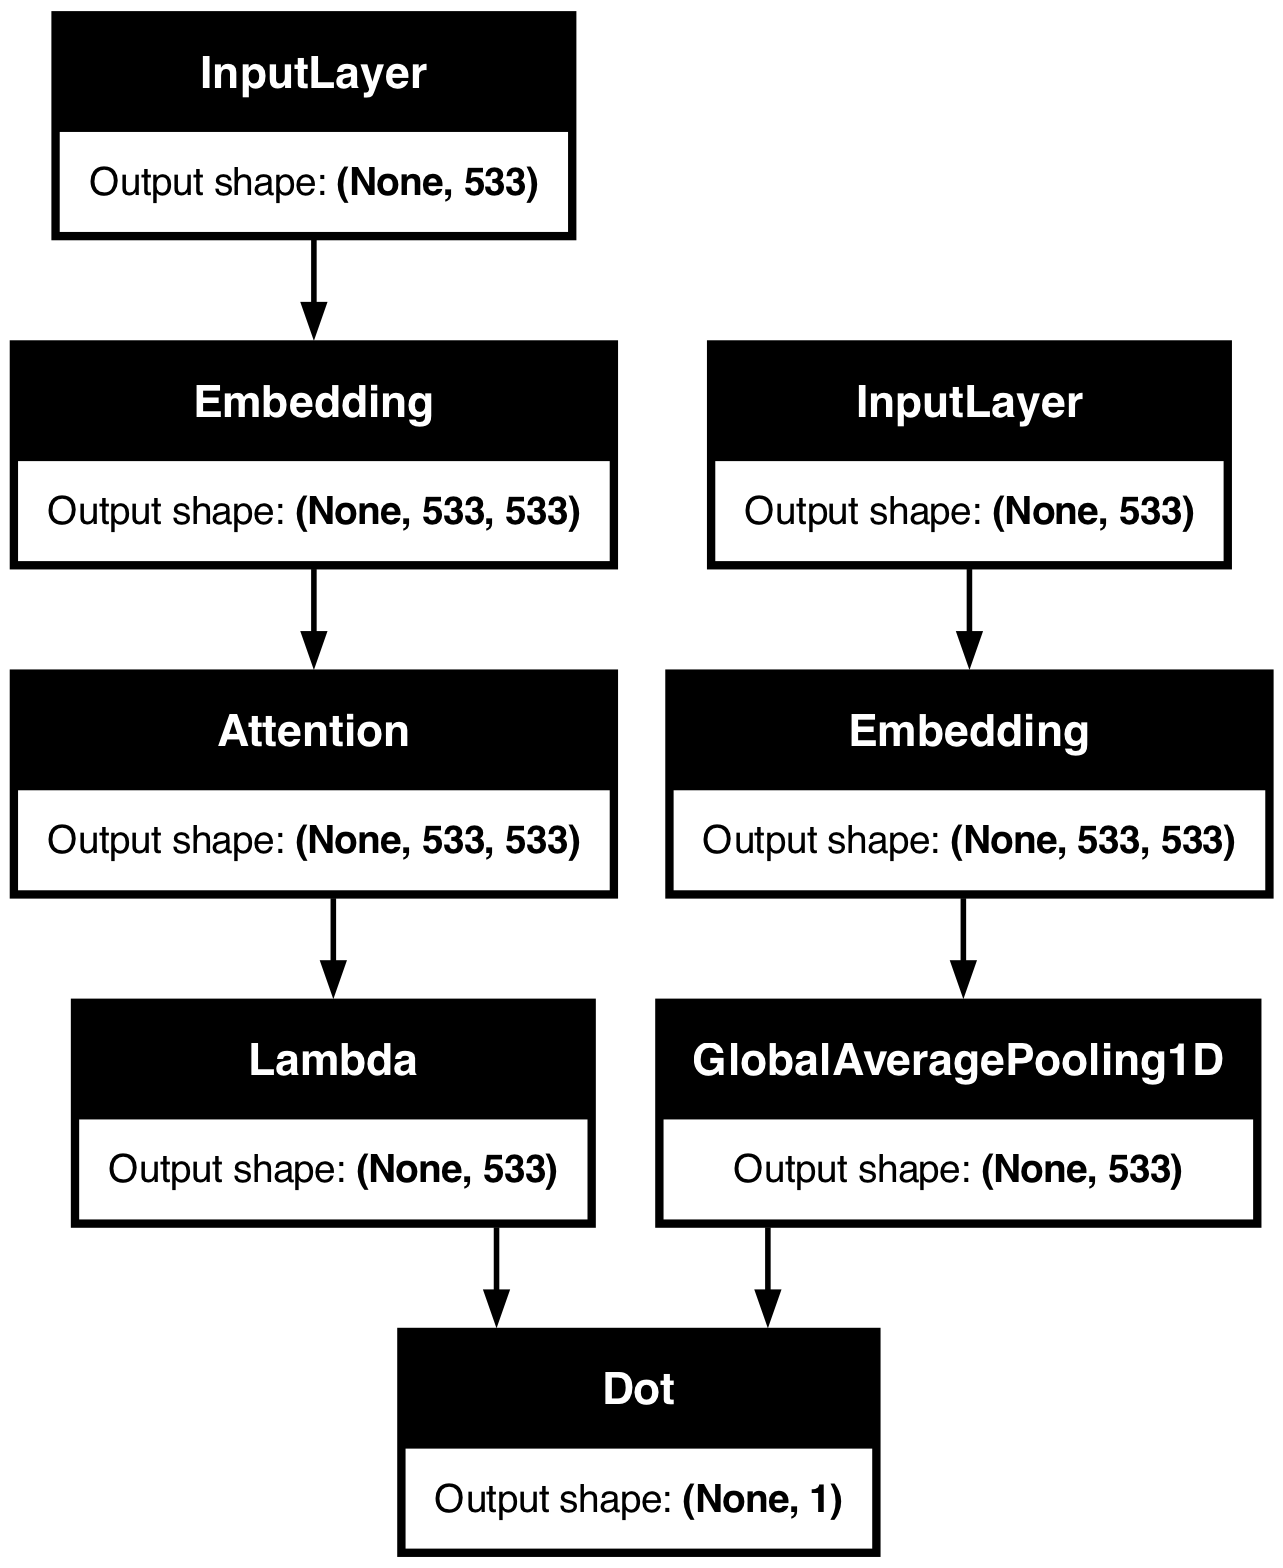

In [ ]:

embedding_size = 512

code_input = tf.keras.Input(shape=(longer_code,), name="code_input")
code_embeding = tf.keras.layers.Embedding(number_code_tokens, embedding_size, name="code_embeding")(code_input)

attention_code = tf.keras.layers.Attention(name="attention_code")([code_embeding, code_embeding])

query_input = tf.keras.Input(shape=(longer_desc,), name="query_input")
query_embeding = tf.keras.layers.Embedding(number_desc_tokens, embedding_size, name="query_embeding")(query_input)


code_output = tf.keras.layers.Lambda(lambda x: K.sum(x, axis=1), name="sum")( attention_code)
query_output = tf.keras.layers.GlobalAveragePooling1D(name="average")( query_embeding)

# This model generates code embedding
model_code = tf.keras.Model(inputs=[code_input], outputs=[code_output], name='model_code')
# This model generates description/query embedding
model_query = tf.keras.Model(inputs=[query_input], outputs=[query_output], name='model_query')

# Cosine similarity
# If normalize set to True, then the output of the dot product is the cosine proximity between the two samples.
cos_sim = tf.keras.layers.Dot(axes=1, normalize=True, name='cos_sim')([query_output, code_output]) 

# This model calculates cosine similarity between code and query pairs
cos_model = tf.keras.Model(inputs=[code_input, query_input], outputs= cos_sim ,name='sim_model')  

loss = tf.keras.layers.Flatten()(cos_sim)
training_model = tf.keras.Model(inputs=[ code_input, query_input], outputs=[cos_sim],name='training_model')

#model_code.compile(loss='cosine_proximity', optimizer='adam')
#model_query.compile(loss='cosine_proximity', optimizer='adam')

cos_model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=["accuracy"]) # extract similarity

# Negative sampling
good_desc_input = tf.keras.Input(shape=(longer_desc,), name="good_desc_input")
bad_desc_input = tf.keras.Input(shape=(longer_desc,), name="bad_desc_input")

good_desc_output = cos_model([code_input, good_desc_input])
bad_desc_output = cos_model([code_input, bad_desc_input])

margin = 0.9
def custom_loss(good_scores, bad_scores, margin=0.9):
    return K.maximum(1e-6, margin - good_scores + bad_scores)

loss = tf.keras.layers.Lambda(lambda scores: custom_loss(scores[0], scores[1], margin),
                              output_shape=lambda x: x[0], name='loss')([good_desc_output, bad_desc_output])

training_model =  tf.keras.Model(inputs=[code_input, good_desc_input, bad_desc_input], outputs=loss,name='training_model')

training_model.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred + 0 * y_true)  

tf.keras.utils.plot_model(cos_model, "cos_model.png", show_shapes=True)

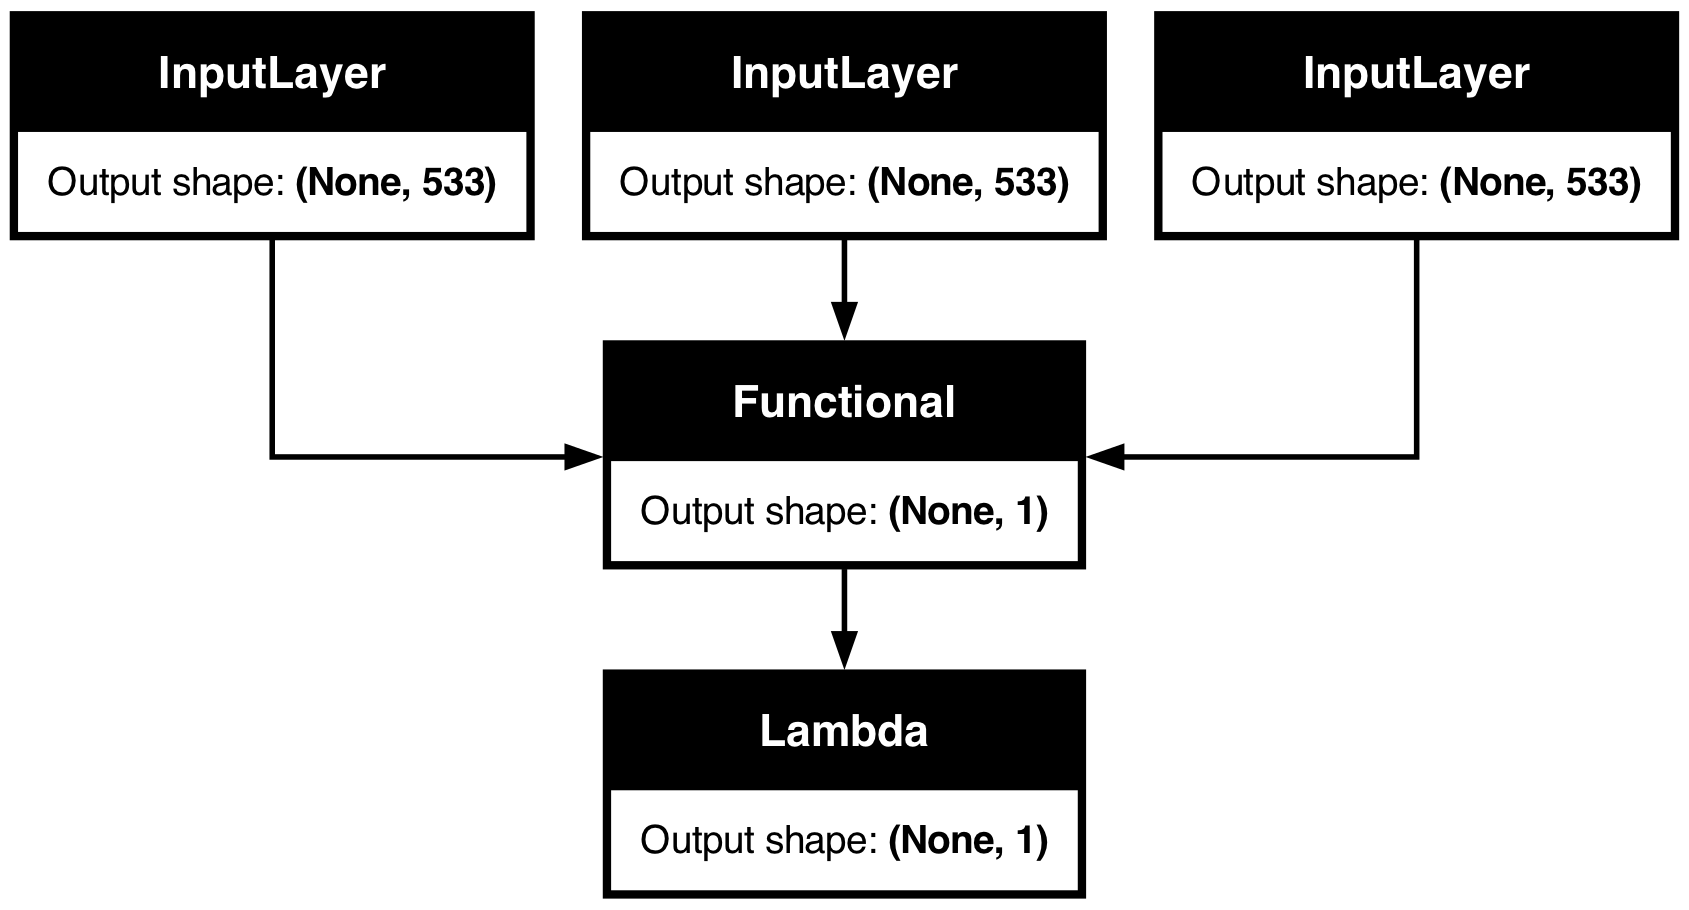

In [ ]:
tf.keras.utils.plot_model(training_model, "training_model.png", show_shapes=True)

In [ ]:
def make_dataset(code_vec, good_desc_vec, bad_desc_vec):
    dataset = tf.data.Dataset.from_tensor_slices(((code_vec, good_desc_vec, bad_desc_vec), 
                                                  np.zeros((code_vec.shape[0], 1))))
    return dataset

In [ ]:
train_dataset = make_dataset(train_code_vec, train_desc_vec, train_bad_desc_vec)
valid_dataset = make_dataset(valid_code_vec, valid_desc_vec, valid_bad_desc_vec)

In [ ]:
BATCH_SIZE = 64

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
EPOCHS = 5

earlystop_callback = EarlyStopping(monitor='val_loss', mode='min', patience=2)

training_model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=[earlystop_callback])


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 0.9002 - val_loss: 0.9007
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 708ms/step - loss: 0.8996 - val_loss: 0.9007
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 681ms/step - loss: 0.8996 - val_loss: 0.9007
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - loss: 0.8996 - val_loss: 0.9007
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - loss: 0.8996 - val_loss: 0.9006


## Test

In [ ]:
dumb_test_label = []

dumb_test_label = np.zeros((test_code_vec.shape[0], 1))

print(test_code_vec.shape)
print(test_desc_vec.shape)

(66, 533)
(66, 533)


In [ ]:
print( training_model.metrics_names)
training_model.evaluate(x=[test_code_vec, test_desc_vec, test_bad_desc_vec], y=dumb_test_label)

['loss']
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.9001 


0.8999886512756348

In [ ]:
print(cos_model.metrics_names)
cos_model.evaluate(x=[test_code_vec, test_desc_vec], y=dumb_test_label)

['loss', 'compile_metrics']
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 1.1921e-07


[1.1920930376163597e-07, 1.0]

In [ ]:
document_embeddings = model_code.predict(train_code_vec)
with open('data/AixBench-L/top_10_similar_docs.txt', 'w') as f:
    # Process each description
    for index, desc in enumerate(tqdm(test_desc_vec)):
        desc = np.expand_dims(desc, axis=0)  # Prepare query embedding
        query_embedding = model_query.predict(desc)

        # Compute cosine similarities between the query embedding and all document embeddings
        similarities = cos_model.predict([np.repeat(query_embedding, len(document_embeddings), axis=0), document_embeddings])

        # Get the indices of the top 10 most similar documents
        top_10_indices = np.argsort(similarities, axis=0)[::-1][:10].flatten()

        # Save the top 10 document IDs (assuming indices map directly to IDs as described)
        f.write(f"{' '.join(str(i + 1) for i in top_10_indices)}\n")


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


  2%|▏         | 1/66 [00:01<01:35,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


  3%|▎         | 2/66 [00:02<01:32,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


  5%|▍         | 3/66 [00:04<01:30,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


  6%|▌         | 4/66 [00:05<01:28,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


  8%|▊         | 5/66 [00:07<01:27,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


  9%|▉         | 6/66 [00:08<01:26,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 11%|█         | 7/66 [00:10<01:24,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 12%|█▏        | 8/66 [00:11<01:24,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 14%|█▎        | 9/66 [00:12<01:22,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


 15%|█▌        | 10/66 [00:14<01:21,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


 17%|█▋        | 11/66 [00:16<01:22,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 18%|█▊        | 12/66 [00:17<01:21,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 20%|█▉        | 13/66 [00:19<01:20,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


 21%|██        | 14/66 [00:20<01:18,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


 23%|██▎       | 15/66 [00:22<01:16,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


 24%|██▍       | 16/66 [00:23<01:15,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 26%|██▌       | 17/66 [00:25<01:13,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 27%|██▋       | 18/66 [00:26<01:11,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


 29%|██▉       | 19/66 [00:28<01:11,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


 30%|███       | 20/66 [00:29<01:09,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


 32%|███▏      | 21/66 [00:31<01:09,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 33%|███▎      | 22/66 [00:32<01:07,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


 35%|███▍      | 23/66 [00:34<01:05,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


 36%|███▋      | 24/66 [00:35<01:05,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


 38%|███▊      | 25/66 [00:37<01:03,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 39%|███▉      | 26/66 [00:38<01:00,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


 41%|████      | 27/66 [00:40<00:57,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 42%|████▏     | 28/66 [00:41<00:55,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 44%|████▍     | 29/66 [00:43<00:53,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


 45%|████▌     | 30/66 [00:44<00:51,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


 47%|████▋     | 31/66 [00:45<00:49,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


 48%|████▊     | 32/66 [00:47<00:48,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


 50%|█████     | 33/66 [00:48<00:46,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 52%|█████▏    | 34/66 [00:50<00:45,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 53%|█████▎    | 35/66 [00:51<00:44,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


 55%|█████▍    | 36/66 [00:53<00:43,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


 56%|█████▌    | 37/66 [00:54<00:43,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


 58%|█████▊    | 38/66 [00:56<00:42,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


 59%|█████▉    | 39/66 [00:57<00:41,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


 61%|██████    | 40/66 [00:59<00:39,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 62%|██████▏   | 41/66 [01:00<00:37,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


 64%|██████▎   | 42/66 [01:02<00:36,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 65%|██████▌   | 43/66 [01:03<00:34,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 67%|██████▋   | 44/66 [01:05<00:32,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


 68%|██████▊   | 45/66 [01:06<00:31,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 70%|██████▉   | 46/66 [01:08<00:29,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 71%|███████   | 47/66 [01:09<00:28,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 73%|███████▎  | 48/66 [01:11<00:26,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


 74%|███████▍  | 49/66 [01:12<00:24,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 76%|███████▌  | 50/66 [01:13<00:23,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 77%|███████▋  | 51/66 [01:15<00:21,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 79%|███████▉  | 52/66 [01:16<00:20,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


 80%|████████  | 53/66 [01:18<00:19,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


 82%|████████▏ | 54/66 [01:19<00:17,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


 83%|████████▎ | 55/66 [01:21<00:16,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 85%|████████▍ | 56/66 [01:22<00:14,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


 86%|████████▋ | 57/66 [01:24<00:13,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


 88%|████████▊ | 58/66 [01:25<00:11,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 89%|████████▉ | 59/66 [01:27<00:10,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 91%|█████████ | 60/66 [01:28<00:08,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 92%|█████████▏| 61/66 [01:30<00:07,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


 94%|█████████▍| 62/66 [01:31<00:05,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 95%|█████████▌| 63/66 [01:32<00:04,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 97%|█████████▋| 64/66 [01:34<00:02,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 98%|█████████▊| 65/66 [01:35<00:01,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


100%|██████████| 66/66 [01:37<00:00,  1.47s/it]


In [ ]:
cos_model.summary()

Model: "sim_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ code_input          │ (None, 533)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ query_input         │ (None, 533)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ code_embeding       │ (None, 533, 533)  │    551,122 │ code_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ query_embeding      │ (None, 533, 533)  │    534,599 │ query_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_code      │ (None, 533, 533)  │          0 │ code_embeding[0]… │
│ (Attention)         │                   │            │ code_embeding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average             │ (None, 533)       │          0 │ query_embeding[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum (Lambda)        │ (None, 533)       │          0 │ attention_code[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cos_sim (Dot)       │ (None, 1)         │          0 │ average[0][0],    │
│                     │                   │            │ sum[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,085,721 (4.14 MB)

 Trainable params: 1,085,721 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
training_model.summary()

Model: "training_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ code_input          │ (None, 533)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ good_desc_input     │ (None, 533)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bad_desc_input      │ (None, 533)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sim_model           │ (None, 1)         │  1,085,721 │ code_input[0][0], │
│ (Functional)        │                   │            │ good_desc_input[… │
│                     │                   │            │ code_input[0][0], │
│                     │                   │            │ bad_desc_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loss (Lambda)       │ (None, 1)         │          0 │ sim_model[0][0],  │
│                     │                   │            │ sim_model[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,257,165 (12.43 MB)

 Trainable params: 1,085,721 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,171,444 (8.28 MB)